In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from pymatgen.core import Lattice, Structure, Composition
from pymatgen.vis.structure_vtk import StructureVis
from pymatgen.transformations import standard_transformations, site_transformations

In [2]:
a = 14.43523963
b = 6.74280580
c = 10.42107312

beta = np.deg2rad(122.18778465)  # conventional a and c angle
angle_D1_a = np.deg2rad(11.35)
angle_D2_a = angle_D1_a + np.pi / 2
angle_D1_c = angle_D1_a - beta
angle_D2_c = angle_D2_a - beta
T_dielectric_from_conventional = np.array(
    [
        [np.cos(angle_D1_a), 0, np.cos(angle_D1_c)],
        [np.cos(angle_D2_a), 0, np.cos(angle_D2_c)],
        [0, -1, 0],  # the minus sign here keeps the handness of the coordinate system.
    ],
)
T_conventional_from_dielectric = np.linalg.inv(T_dielectric_from_conventional)

In [3]:
def transform(T, x, y, z):
    return tuple(
        [T[kk][0] * x + T[kk][1] * y + T[kk][2] * z for kk in range(3)]
    )

In [4]:
conventional_structure = Structure.from_file("Y2SiO5-mp3520.cif")
for s in conventional_structure.sites:
    for kk in s.species._data:
        s.species._data[kk] = int(s.species._data[kk])  # fix a bug in pymatgen visualization

sites_1 = {}
for kk, s in enumerate(conventional_structure.sites):
    if s.species_string == "Y3+":
        max_bond_distance = 2.9  # 2.7 to 3.1 gives the correct numbers of neighbors (7 / 6).
        if len(conventional_structure.get_neighbors(s, max_bond_distance)) == 7:
            sites_1[kk] = "Eu3+"
conventional_structure = site_transformations.ReplaceSiteSpeciesTransformation(sites_1).apply_transformation(conventional_structure)
conventional_atoms = []
conventional_a = []
conventional_b = []
conventional_c = []
for s in conventional_structure.sites:
    conventional_atoms.append(s.species_string)
    conventional_a.append(s.a * a)
    conventional_b.append(s.b * b)
    conventional_c.append(s.c * c)
for s in conventional_structure.sites:  # amplify 
    conventional_atoms.append(s.species_string)
    conventional_a.append(s.a * a + a)
    conventional_b.append(s.b * b)
    conventional_c.append(s.c * c)
    

conventional_atoms = np.array(conventional_atoms)
conventional_a = np.array(conventional_a) - np.average(conventional_a)
conventional_b = np.array(conventional_b) - np.average(conventional_b)
conventional_c = np.array(conventional_c) - np.average(conventional_c)

conventional_D1, conventional_D2, conventional_Db = transform(
    T_dielectric_from_conventional, conventional_a, conventional_b, conventional_c,
)

# conventional_atoms = []
# conventional_D1 = []
# conventional_D2 = []
# conventional_Db = []
# for s in conventional_structure.sites:
#     conventional_atoms.append(s.species_string)
#     conventional_D1.append(s.coords[0])
#     conventional_D2.append(s.coords[2])
#     conventional_Db.append(-s.coords[1])
# conventional_atoms = np.array(conventional_atoms)
# conventional_D1 = np.array(conventional_D1) - np.average(conventional_D1)
# conventional_D2 = np.array(conventional_D2) - np.average(conventional_D2)
# conventional_Db = np.array(conventional_Db) - np.average(conventional_Db)

conventional_Eu_mask = conventional_atoms == "Eu3+"
conventional_Y_mask = conventional_atoms == "Y3+"
conventional_Si_mask = conventional_atoms == "Si4+"
conventional_O_mask = conventional_atoms == "O2-"

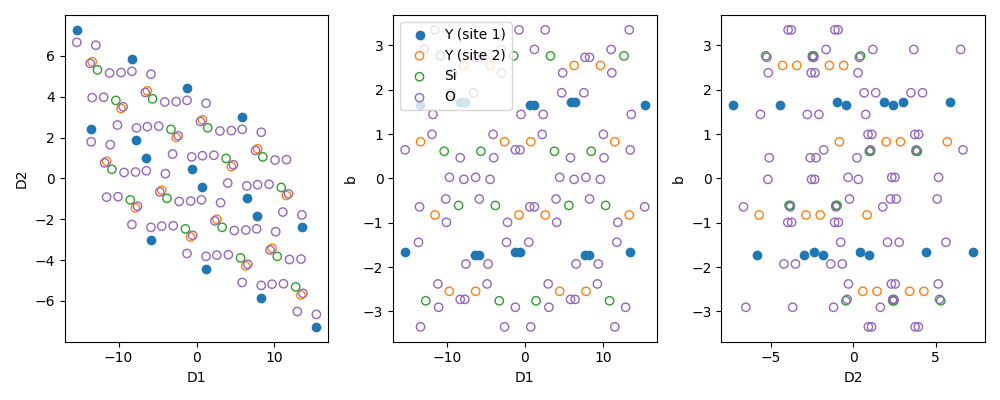

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].scatter(conventional_D1[conventional_Eu_mask], conventional_D2[conventional_Eu_mask], color="C0")
ax[0].scatter(conventional_D1[conventional_Y_mask], conventional_D2[conventional_Y_mask], edgecolor="C1", facecolor="none")
ax[0].scatter(conventional_D1[conventional_Si_mask], conventional_D2[conventional_Si_mask], edgecolor="C2", facecolor="none")
ax[0].scatter(conventional_D1[conventional_O_mask], conventional_D2[conventional_O_mask], edgecolor="C4", facecolor="none")
ax[0].set_xlabel("D1")
ax[0].set_ylabel("D2")

ax[1].scatter(conventional_D1[conventional_Eu_mask], conventional_Db[conventional_Eu_mask], label="Y (site 1)", color="C0")
ax[1].scatter(conventional_D1[conventional_Y_mask], conventional_Db[conventional_Y_mask], label="Y (site 2)", edgecolor="C1", facecolor="none")
ax[1].scatter(conventional_D1[conventional_Si_mask], conventional_Db[conventional_Si_mask], label="Si", edgecolor="C2", facecolor="none")
ax[1].scatter(conventional_D1[conventional_O_mask], conventional_Db[conventional_O_mask], label="O", edgecolor="C4", facecolor="none")
ax[1].set_xlabel("D1")
ax[1].set_ylabel("b")
ax[1].legend()

ax[2].scatter(conventional_D2[conventional_Eu_mask], conventional_Db[conventional_Eu_mask], color="C0")
ax[2].scatter(conventional_D2[conventional_Y_mask], conventional_Db[conventional_Y_mask], edgecolor="C1", facecolor="none")
ax[2].scatter(conventional_D2[conventional_Si_mask], conventional_Db[conventional_Si_mask], edgecolor="C2", facecolor="none")
ax[2].scatter(conventional_D2[conventional_O_mask], conventional_Db[conventional_O_mask], edgecolor="C4", facecolor="none")
ax[2].set_xlabel("D2")
ax[2].set_ylabel("b")

plt.tight_layout()
plt.show()

In [111]:
primitive_structure = conventional_structure.get_primitive_structure()
primitive_atoms = []
primitive_x = []
primitive_y = []
primitive_z = []
for kk, s in enumerate(primitive_structure.sites):
    primitive_atoms.append(s.species_string)
    primitive_x.append(s.coords[0])
    primitive_y.append(s.coords[1])
    primitive_z.append(s.coords[2])

primitive_atoms = np.array(primitive_atoms)
primitive_x_avg = np.average(primitive_x)
primitive_x = np.array(primitive_x) - primitive_x_avg
primitive_y_avg = np.average(primitive_y)
primitive_y = np.array(primitive_y) - primitive_y_avg
primitive_z_avg = np.average(primitive_z)
primitive_z = np.array(primitive_z) - primitive_z_avg

primitive_Eu_mask = primitive_atoms == "Eu3+"
primitive_Y_mask = primitive_atoms == "Y3+"
primitive_Si_mask = primitive_atoms == "Si4+"
primitive_O_mask = primitive_atoms == "O2-"

primitive_nearest_O_x = []
primitive_nearest_O_y = []
primitive_nearest_O_z = []
for kk, Eu_site in enumerate(np.array(primitive_structure.sites)[primitive_Eu_mask]):
    distances = []
    for ll, O_site in enumerate(np.array(primitive_structure.sites)[primitive_O_mask]):
        distances.append(primitive_structure.get_distance(kk, ll))
    nearest_O_site = np.array(primitive_structure.sites)[primitive_O_mask][np.argmin(distances)]
    primitive_nearest_O_x.append(nearest_O_site.coords[0] - primitive_x_avg)
    primitive_nearest_O_y.append(nearest_O_site.coords[1] - primitive_y_avg)
    primitive_nearest_O_z.append(nearest_O_site.coords[2] - primitive_z_avg)
primitive_nearest_O_x = np.array(primitive_nearest_O_x)
primitive_nearest_O_y = np.array(primitive_nearest_O_y)
primitive_nearest_O_z = np.array(primitive_nearest_O_z)

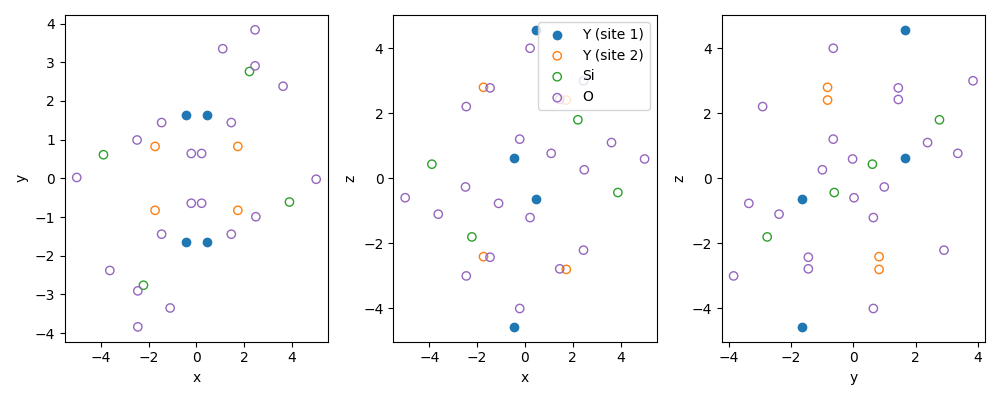

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].scatter(primitive_x[primitive_Eu_mask], primitive_y[primitive_Eu_mask], color="C0")
ax[0].scatter(primitive_x[primitive_Y_mask], primitive_y[primitive_Y_mask], edgecolor="C1", facecolor="none")
ax[0].scatter(primitive_x[primitive_Si_mask], primitive_y[primitive_Si_mask], edgecolor="C2", facecolor="none")
ax[0].scatter(primitive_x[primitive_O_mask], primitive_y[primitive_O_mask], edgecolor="C4", facecolor="none")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(primitive_x[primitive_Eu_mask], primitive_z[primitive_Eu_mask], label="Y (site 1)", color="C0")
ax[1].scatter(primitive_x[primitive_Y_mask], primitive_z[primitive_Y_mask], label="Y (site 2)", edgecolor="C1", facecolor="none")
ax[1].scatter(primitive_x[primitive_Si_mask], primitive_z[primitive_Si_mask], label="Si", edgecolor="C2", facecolor="none")
ax[1].scatter(primitive_x[primitive_O_mask], primitive_z[primitive_O_mask], label="O", edgecolor="C4", facecolor="none")
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
ax[1].legend()

ax[2].scatter(primitive_y[primitive_Eu_mask], primitive_z[primitive_Eu_mask], color="C0")
ax[2].scatter(primitive_y[primitive_Y_mask], primitive_z[primitive_Y_mask], edgecolor="C1", facecolor="none")
ax[2].scatter(primitive_y[primitive_Si_mask], primitive_z[primitive_Si_mask], edgecolor="C2", facecolor="none")
ax[2].scatter(primitive_y[primitive_O_mask], primitive_z[primitive_O_mask], edgecolor="C4", facecolor="none")
ax[2].set_xlabel("y")
ax[2].set_ylabel("z")

plt.tight_layout()
plt.show()

In [113]:
def get_rotation_matrix(v1, v2):
    v1_unit = v1 / np.linalg.norm(v1)
    v2_unit = v2 / np.linalg.norm(v2)
    v = np.cross(v1_unit, v2_unit)
    s = np.linalg.norm(v)
    c = v1_unit @ v2_unit
    m = np.array(  # skew_symmetric_cross_product_v
        [
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ]
    )
    return np.identity(3) + m + m @ m * (1 - c) / s**2

vec_xyz = np.array([primitive_x[0], primitive_y[0], primitive_z[0]])
conventional_index = 0
vec_D1D2Db = np.array([conventional_D1[conventional_index], conventional_D2[conventional_index], conventional_Db[conventional_index]])
T_primitive_to_dielectric = get_rotation_matrix(vec_xyz, vec_D1D2Db)
T_dielectric_to_primitive = np.linalg.inv(T_primitive_to_dielectric)
primitive_D1, primitive_D2, primitive_Db = transform(
    T_primitive_to_dielectric, primitive_x, primitive_y, primitive_z,
)
primitive_nearest_O_D1, primitive_nearest_O_D2, primitive_nearest_O_Db = transform(
    T_primitive_to_dielectric, primitive_nearest_O_x, primitive_nearest_O_y, primitive_nearest_O_z,
)

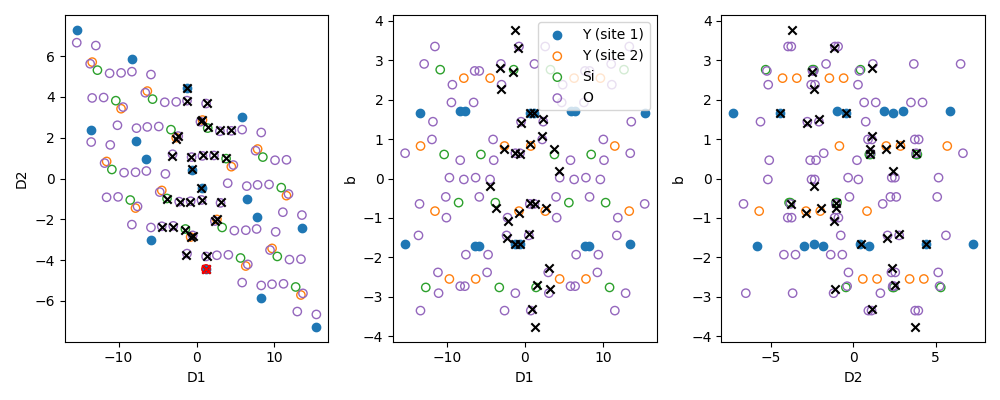

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].scatter(conventional_D1[conventional_Eu_mask], conventional_D2[conventional_Eu_mask], color="C0")
ax[0].scatter(conventional_D1[conventional_Y_mask], conventional_D2[conventional_Y_mask], edgecolor="C1", facecolor="none")
ax[0].scatter(conventional_D1[conventional_Si_mask], conventional_D2[conventional_Si_mask], edgecolor="C2", facecolor="none")
ax[0].scatter(conventional_D1[conventional_O_mask], conventional_D2[conventional_O_mask], edgecolor="C4", facecolor="none")
ax[0].scatter(primitive_D1, primitive_D2, color="k", marker="x")
ax[0].scatter(primitive_D1[0], primitive_D2[0], color="red", marker="x")  # ion used for matching the coordinates.
ax[0].scatter(conventional_D1[conventional_index], conventional_D2[conventional_index], color="red", marker="o", facecolor="none")  # ion used for matching the coordinates.
ax[0].set_xlabel("D1")
ax[0].set_ylabel("D2")

ax[1].scatter(conventional_D1[conventional_Eu_mask], conventional_Db[conventional_Eu_mask], label="Y (site 1)", color="C0")
ax[1].scatter(conventional_D1[conventional_Y_mask], conventional_Db[conventional_Y_mask], label="Y (site 2)", edgecolor="C1", facecolor="none")
ax[1].scatter(conventional_D1[conventional_Si_mask], conventional_Db[conventional_Si_mask], label="Si", edgecolor="C2", facecolor="none")
ax[1].scatter(conventional_D1[conventional_O_mask], conventional_Db[conventional_O_mask], label="O", edgecolor="C4", facecolor="none")
ax[1].scatter(primitive_D1, primitive_Db, color="k", marker="x")
ax[1].set_xlabel("D1")
ax[1].set_ylabel("b")
ax[1].legend()

ax[2].scatter(conventional_D2[conventional_Eu_mask], conventional_Db[conventional_Eu_mask], color="C0")
ax[2].scatter(conventional_D2[conventional_Y_mask], conventional_Db[conventional_Y_mask], edgecolor="C1", facecolor="none")
ax[2].scatter(conventional_D2[conventional_Si_mask], conventional_Db[conventional_Si_mask], edgecolor="C2", facecolor="none")
ax[2].scatter(conventional_D2[conventional_O_mask], conventional_Db[conventional_O_mask], edgecolor="C4", facecolor="none")
ax[2].scatter(primitive_D2, primitive_Db, color="k", marker="x")
ax[2].set_xlabel("D2")
ax[2].set_ylabel("b")

plt.tight_layout()
plt.show()

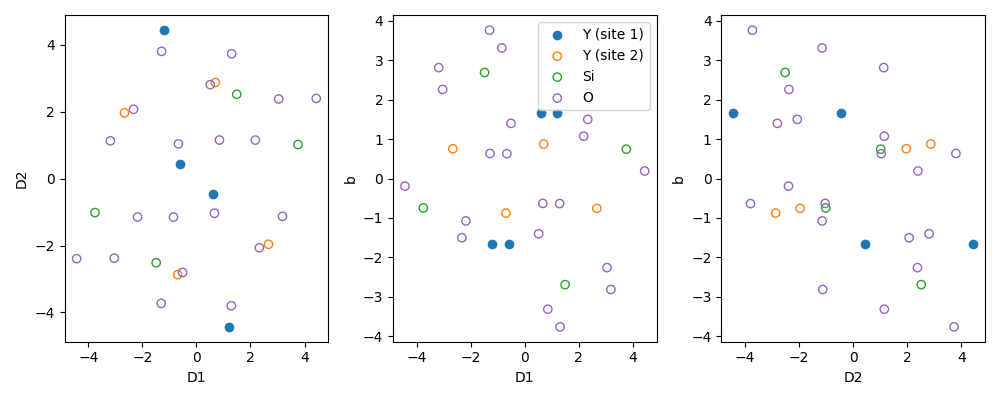

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].scatter(primitive_D1[primitive_Eu_mask], primitive_D2[primitive_Eu_mask], color="C0")
ax[0].scatter(primitive_D1[primitive_Y_mask], primitive_D2[primitive_Y_mask], edgecolor="C1", facecolor="none")
ax[0].scatter(primitive_D1[primitive_Si_mask], primitive_D2[primitive_Si_mask], edgecolor="C2", facecolor="none")
ax[0].scatter(primitive_D1[primitive_O_mask], primitive_D2[primitive_O_mask], edgecolor="C4", facecolor="none")
ax[0].set_xlabel("D1")
ax[0].set_ylabel("D2")

ax[1].scatter(primitive_D1[primitive_Eu_mask], primitive_Db[primitive_Eu_mask], label="Y (site 1)", color="C0")
ax[1].scatter(primitive_D1[primitive_Y_mask], primitive_Db[primitive_Y_mask], label="Y (site 2)", edgecolor="C1", facecolor="none")
ax[1].scatter(primitive_D1[primitive_Si_mask], primitive_Db[primitive_Si_mask], label="Si", edgecolor="C2", facecolor="none")
ax[1].scatter(primitive_D1[primitive_O_mask], primitive_Db[primitive_O_mask], label="O", edgecolor="C4", facecolor="none")
ax[1].set_xlabel("D1")
ax[1].set_ylabel("b")
ax[1].legend()

ax[2].scatter(primitive_D2[primitive_Eu_mask], primitive_Db[primitive_Eu_mask], color="C0")
ax[2].scatter(primitive_D2[primitive_Y_mask], primitive_Db[primitive_Y_mask], edgecolor="C1", facecolor="none")
ax[2].scatter(primitive_D2[primitive_Si_mask], primitive_Db[primitive_Si_mask], edgecolor="C2", facecolor="none")
ax[2].scatter(primitive_D2[primitive_O_mask], primitive_Db[primitive_O_mask], edgecolor="C4", facecolor="none")
ax[2].set_xlabel("D2")
ax[2].set_ylabel("b")

plt.tight_layout()
plt.show()

In [100]:
primitive_abc_xyz = []
primitive_abc_xyz.append(primitive_structure.lattice.get_cartesian_coords([1, 0, 0]))
primitive_abc_xyz.append(primitive_structure.lattice.get_cartesian_coords([0, 1, 0]))
primitive_abc_xyz.append(primitive_structure.lattice.get_cartesian_coords([0, 0, 1]))
primitive_corners_xyz = []
for a in [-0.5, 0.5]:
    for b in [-0.5, 0.5]:
        for c in [-0.5, 0.5]:
            primitive_corners_xyz.append(
                primitive_structure.lattice.get_cartesian_coords([a, b, c])
            )
primitive_corners_D1D2b = [
    transform(T_primitive_to_dielectric, *tuple(list(corner_xyz))) for corner_xyz in primitive_corners_xyz
]

def get_edge_indices_from_corners(corners):
    # does not work. Don't use.
    distance_matrix = []
    for kk, corner in enumerate(corners):
        distance_matrix.append([])
        for corner1 in corners:
            distance_matrix[kk].append(np.linalg.norm(np.array(corner) - np.array(corner1)))
    distance_matrix = np.array(distance_matrix)

    edge_indices = [(kk, ll) for kk in range(len(corners)) for ll in range(len(corners)) if kk != ll]
    for kk, ll in reversed(edge_indices):
        if (ll, kk) in edge_indices:
            edge_indices.remove((kk, ll))
            
    edges_connected_to_corners = {}
    for kk in range(len(corners)):
         edges_connected_to_corners[kk] = 7

    #for kk, ll in np.dstack(np.unravel_index(reversed(np.argsort(distance_matrix.ravel())), distance_matrix.shape))[0][8:]:
    # total_edge_counter = 0
    # for kk, ll in np.dstack(np.unravel_index(np.argsort(distance_matrix.ravel()), distance_matrix.shape))[0][8:]:  # the smallest 8 elements are zeros
    #     if (kk, ll) not in edge_indices and (ll, kk) not in edge_indices:
    #         has_shared_edge = False
    #         for shared_index in range(len(corners)):
    #             kk_edge = (kk, shared_index) in edge_indices or (shared_index, kk) in edge_indices
    #             ll_edge = (ll, shared_index) in edge_indices or (shared_index, ll) in edge_indices
    #             if kk_edge and ll_edge:
    #                 has_shared_edge = True
    #                 break
    #         if not has_shared_edge:
    #             if edges_connected_to_corners[kk] < 3 and edges_connected_to_corners[ll] < 3:
    #                 edge_indices.append((kk, ll))
    #                 edges_connected_to_corners[kk] += 1
    #                 edges_connected_to_corners[ll] += 1
    #                 total_edge_counter += 1
    #     if total_edge_counter == 12:
    #         break

        
    # for corner_index, distance_vector in enumerate(distance_matrix):
    #     for corner1_index in np.argsort(distance_vector)[1:4]:
    #         if (corner_index, corner1_index) not in edge_indices and (corner1_index, corner_index) not in edge_indices:
    #             edge_indices.append((corner_index, corner1_index))
    return edge_indices

def get_edge_indices_from_corners():
    return [(0, 1), (2, 3), (4, 5), (6, 7), (0, 2), (1, 3), (4, 6), (5, 7), (0, 4), (1, 5), (2, 6), (3, 7)]

primitive_edges_D1D2b = [
    (primitive_corners_D1D2b[kk], primitive_corners_D1D2b[ll]) for kk, ll in get_edge_indices_from_corners()
]

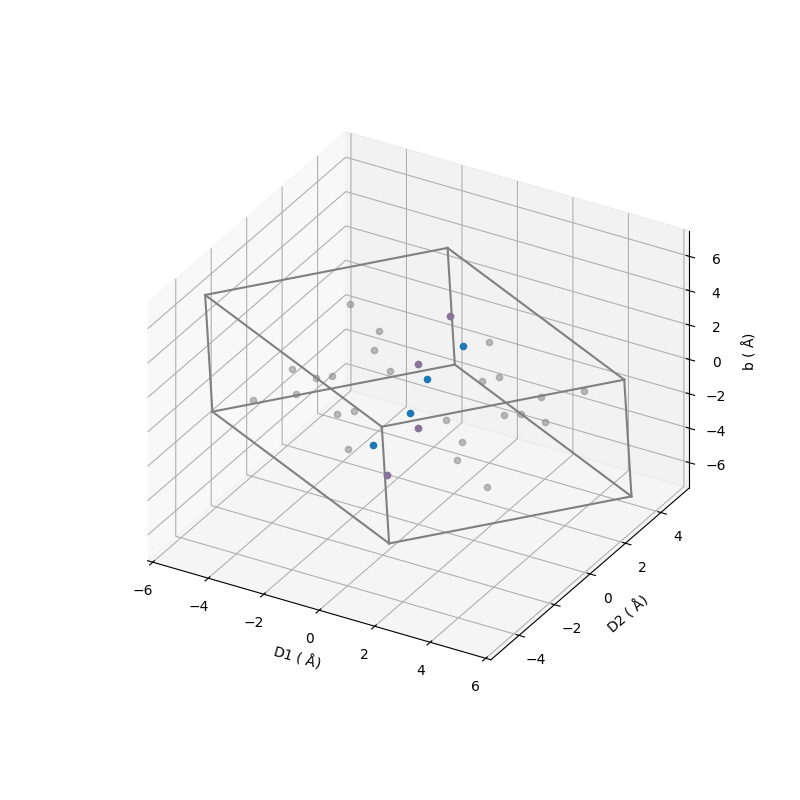

In [159]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.set_proj_type('ortho')
for mask in [primitive_Eu_mask]:
    ax.scatter(primitive_D1[mask], primitive_D2[mask], primitive_Db[mask], depthshade=False)
for mask in [primitive_Y_mask, primitive_Si_mask, primitive_O_mask]:
    ax.scatter(primitive_D1[mask], primitive_D2[mask], primitive_Db[mask], alpha=0.5, color="gray", depthshade=False)
ax.scatter(primitive_nearest_O_D1, primitive_nearest_O_D2, primitive_nearest_O_Db, depthshade=False, color="C4")
#ax.scatter(*tuple(list(np.transpose(primitive_corners_D1D2b))), color="k")
for edge in primitive_edges_D1D2b:
    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color="gray")
ax.set_xlabel("D1 ($\\mathrm{~\\AA}$)")
ax.set_ylabel("D2 ($\\mathrm{~\\AA}$)")
ax.set_zlabel("b ($\\mathrm{~\\AA}$)")
plt.show()

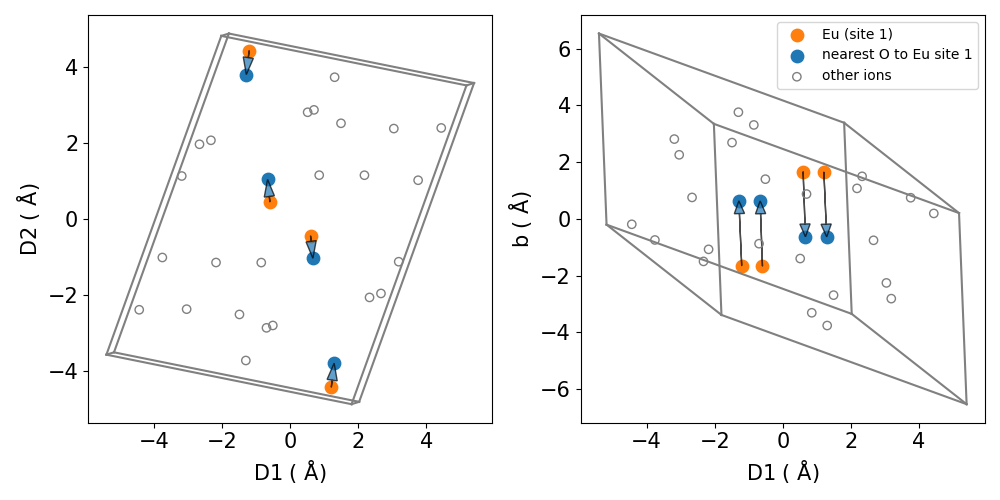

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
s_major = 80
fontsize = 15
ax[0].tick_params(labelsize=fontsize)
ax[0].scatter(primitive_D1[primitive_Eu_mask], primitive_D2[primitive_Eu_mask], color="C1", s=s_major)
ax[0].scatter(primitive_D1[primitive_Y_mask], primitive_D2[primitive_Y_mask], edgecolor="gray", facecolor="none")
ax[0].scatter(primitive_D1[primitive_Si_mask], primitive_D2[primitive_Si_mask], edgecolor="gray", facecolor="none")
ax[0].scatter(primitive_D1[primitive_O_mask], primitive_D2[primitive_O_mask], edgecolor="gray", facecolor="none")
ax[0].scatter(primitive_nearest_O_D1, primitive_nearest_O_D2, color="C0", s=s_major)
for kk in range(len(primitive_D1[primitive_Eu_mask])):
    ax[0].arrow(
        primitive_D1[primitive_Eu_mask][kk], primitive_D2[primitive_Eu_mask][kk], 
        primitive_nearest_O_D1[kk] - primitive_D1[primitive_Eu_mask][kk], primitive_nearest_O_D2[kk] - primitive_D2[primitive_Eu_mask][kk],
        head_width=0.3, alpha=0.7, length_includes_head=True,
    )
ax[0].set_xlabel("D1 ($\\mathrm{~\\AA}$)", fontsize=fontsize)
ax[0].set_ylabel("D2 ($\\mathrm{~\\AA}$)", fontsize=fontsize)
for edge in primitive_edges_D1D2b:
    ax[0].plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], color="gray")

ax[1].tick_params(labelsize=fontsize)
ax[1].scatter(primitive_D1[primitive_Eu_mask], primitive_Db[primitive_Eu_mask], label="Eu (site 1)", color="C1", s=s_major)
ax[1].scatter(primitive_D1[primitive_Si_mask], primitive_Db[primitive_Si_mask], edgecolor="gray", facecolor="none")
ax[1].scatter(primitive_D1[primitive_O_mask], primitive_Db[primitive_O_mask], edgecolor="gray", facecolor="none")
ax[1].scatter(primitive_nearest_O_D1, primitive_nearest_O_Db, color="C0", label="nearest O to Eu site 1", s=s_major)
for kk in range(len(primitive_D1[primitive_Eu_mask])):
    ax[1].arrow(
        primitive_D1[primitive_Eu_mask][kk], primitive_Db[primitive_Eu_mask][kk], 
        primitive_nearest_O_D1[kk] - primitive_D1[primitive_Eu_mask][kk], primitive_nearest_O_Db[kk] - primitive_Db[primitive_Eu_mask][kk],
        head_width=0.3, alpha=0.7, length_includes_head=True,
    )
ax[1].scatter(primitive_D1[primitive_Y_mask], primitive_Db[primitive_Y_mask], label="other ions", edgecolor="gray", facecolor="none")
ax[1].set_xlabel("D1 ($\\mathrm{~\\AA}$)", fontsize=fontsize)
ax[1].set_ylabel("b ($\\mathrm{~\\AA}$)", fontsize=fontsize)
ax[1].legend()
for edge in primitive_edges_D1D2b:
    ax[1].plot([edge[0][0], edge[1][0]], [edge[0][2], edge[1][2]], color="gray")

plt.tight_layout()
plt.savefig("model.svg")
plt.show()